# Online Joint State and Parameters Estimation for HAR SSM
State space model
\begin{align*}
    &\Theta_{t}^{(1)} = A(\Theta^{(2)})\Theta_{t-1}^{(1)} + \mathbf{p}_{t_{\theta}} \quad \mathbf{p}_{t_{\theta}} \sim \mathcal{N}(\mathbf{0}, \mathbf{I}\gamma_\theta^{-1}) \\
    &\mathbf{x}_t = A(\Theta_{t}^{(1)})\mathbf{x}_{t-1} + \mathbf{p}_{t_{x}} \quad \mathbf{p}_{t_{x}} \sim \mathcal{N}(\mathbf{0}, \mathbf{I}\gamma_x^{-1}) \\
    &y_t = \mathbf{c}^\text{T}\mathbf{x}_t + m_t \quad v_t \sim \mathcal{N}(0, \gamma_y^{-1})
\end{align*}

where
\begin{align*}
    &\Theta^{(1)}_t = (\theta_t, \theta_{t-1}, \dots, \theta_{t-p+1})^\text{T} \quad \Theta^{(1)}_{t-1} = (\theta_{t-1}, \theta_{t-2}, \dots, \theta_{t-p})^\text{T} \\
    &\mathbf{x}_t = (x_t, x_{t-1}, \dots, x_{t-p+1})^\text{T} \quad \mathbf{x}_{t-1} = (x_{t-1}, x_{t-2}, \dots, x_{t-p})^\text{T} 
    \\ \\
    &A(\Theta) = 
    \begin{bmatrix}
         \Theta^{T} \\
         \mathbf{I}_{p-1} \quad \mathbf{0}
    \end{bmatrix}
    \quad
    \mathbf{I} = \mathbf{I}_p = 
    \begin{bmatrix}
        1 & 0 & 0 & \dots & 0 \\ 
        0 & 1 & 0 & \dots & 0 \\   
        \vdots & \vdots & \vdots & \ddots & \vdots \\
        0 & 0 & 0 & \dots & 1
    \end{bmatrix} \\
\end{align*}

Note: we clamp $\gamma_y = \frac{1}{200}$ (high variance)

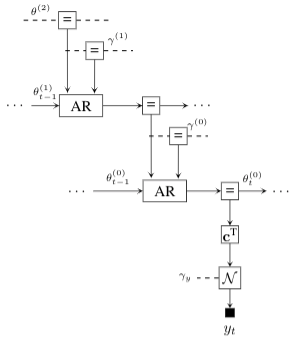

In [2]:
using Images
img = load("../ffgs/HAR-online.png")

In [2]:
using ProgressMeter
using Revise
using ForneyLab
using Random
using Plots
using LaTeXStrings
using StatsPlots
include( "../AR-node/autoregression.jl")
include( "../AR-node/observationAR.jl")
include("../AR-node/rules_prototypes.jl")
include("../AR-node/vmp_rules.jl")
include("../helpers/functions.jl")
include("../data/ARdata.jl")
import Main.ARdata: generateHAR, generateAR, loadAR
import LinearAlgebra.I, LinearAlgebra.Symmetric
import ForneyLab: unsafeCov, unsafeMean, unsafePrecision

In [3]:
Random.seed!(42)

HARorder = 1

v_θ1 = 0.5
v_x = 100.0

dataHAR = generateHAR(1000, HARorder, levels=2, nvars=[v_θ1, v_x], stat=true)
coefs = dataHAR[1]
θ = [θ[1] for θ in dataHAR[2]]
x = [x[1] for x in dataHAR[3]]

# Observations
v_y = 200.0
y = [xi[1] + sqrt(v_y)*randn() for xi in dataHAR[3]];

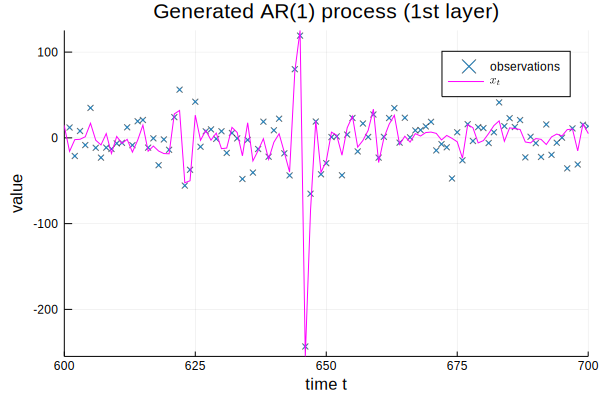

In [4]:
# Plotting the data
from = 600; upto = 700;
plot(xlims=(from, upto), ylims=(minimum(x[from:upto]), maximum(x[from:upto])))
scatter!(y, markershape = :xcross, markeralpha = 0.6,
        markersize = 2, xlabel="time t", ylabel="value", label="observations")
plot!(x, color=:magenta, label=L"x_t", title="Generated AR($HARorder) process (1st layer)")

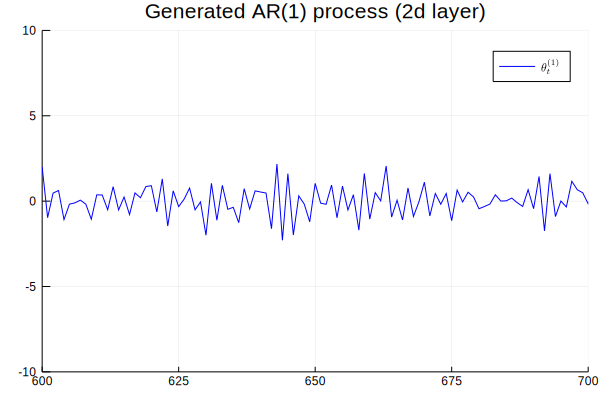

In [5]:
plot(xlims=(from, upto), ylims=(-10, 10))
plot!(θ, color=:blue, label=L"\theta_t^{(1)}", title="Generated AR($HARorder) process (2d layer)")

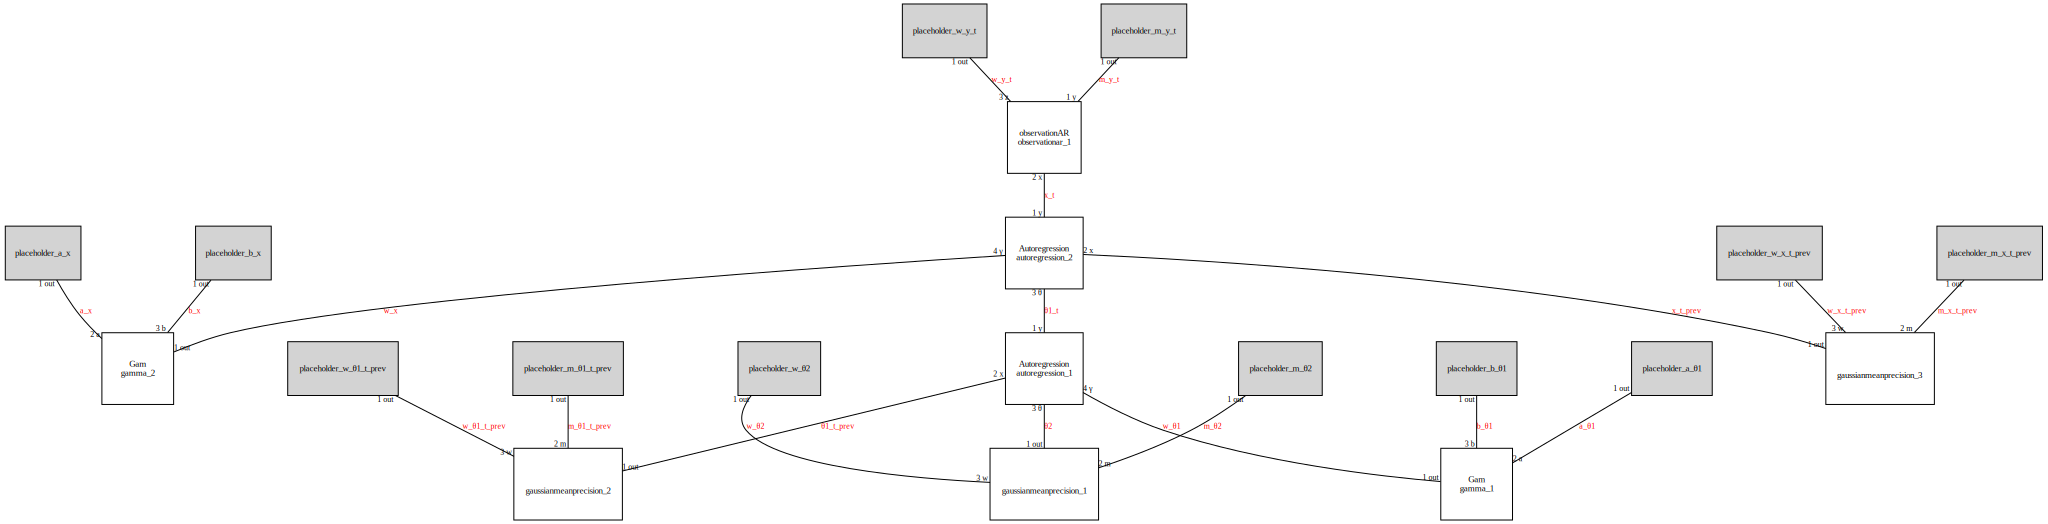

In [6]:
# Creating the graph
g = FactorGraph()

# Upper layer
@RV m_θ2
@RV w_θ2
@RV θ2 ~ GaussianMeanPrecision(m_θ2, w_θ2)
@RV a_θ1
@RV b_θ1
@RV w_θ1 ~ Gamma(a_θ1, b_θ1)
@RV m_θ1_t_prev
@RV w_θ1_t_prev
@RV θ1_t_prev ~ GaussianMeanPrecision(m_θ1_t_prev, w_θ1_t_prev)
@RV θ1_t = AR(θ2, θ1_t_prev, w_θ1)

# Second layer
@RV a_x
@RV b_x
@RV w_x ~ Gamma(a_x, b_x)
@RV m_x_t_prev
@RV w_x_t_prev
@RV x_t_prev ~ GaussianMeanPrecision(m_x_t_prev, w_x_t_prev)
@RV x_t = AR(θ1_t, x_t_prev, w_x)

# Observation
@RV m_y_t
@RV w_y_t
# FIXME
ARorder = HARorder
observationAR(m_y_t, x_t, w_y_t)

# Placeholders for prior of upper layer
placeholder(m_θ2, :m_θ2, dims=(HARorder,))
placeholder(w_θ2, :w_θ2, dims=(HARorder, HARorder))
placeholder(a_θ1, :a_θ1)
placeholder(b_θ1, :b_θ1)
placeholder(m_θ1_t_prev, :m_θ1_t_prev, dims=(HARorder,))
placeholder(w_θ1_t_prev, :w_θ1_t_prev, dims=(HARorder, HARorder))

# Placeholders for prior of bottom layer
placeholder(a_x, :a_x)
placeholder(b_x, :b_x)
placeholder(m_x_t_prev, :m_x_t_prev, dims=(HARorder,))
placeholder(w_x_t_prev, :w_x_t_prev, dims=(HARorder, HARorder))

# Placeholder for observations
placeholder(m_y_t, :m_y_t)
placeholder(w_y_t, :w_y_t)

ForneyLab.draw(g)

In [7]:
# Specify recognition factorization
q = RecognitionFactorization(θ1_t, θ2, θ1_t_prev, w_θ1, x_t, x_t_prev, w_x,
                             ids=[:θ1_t :θ2 :θ1_t_prev :W_θ1 :X_t :X_t_prev :W_x])

algo = variationalAlgorithm(q)
algoF = freeEnergyAlgorithm(q)

# Load algorithms
eval(Meta.parse(algo))
eval(Meta.parse(algoF))

freeEnergy (generic function with 1 method)

In [8]:
# Storage for upper layer
m_θ1 = Vector{Vector{Float64}}(undef, length(y))
w_θ1 = Vector{Array{Float64, 2}}(undef, length(y))
m_θ1_prev = Vector{Vector{Float64}}(undef, length(y))
w_θ1_prev = Vector{Array{Float64, 2}}(undef, length(y))
m_θ2 = Vector{Vector{Float64}}(undef, length(y))
w_θ2 = Vector{Array{Float64, 2}}(undef, length(y))
a_θ1 = Vector{Float64}(undef, length(y))
b_θ1 = Vector{Float64}(undef, length(y))

# Storage for bottom layer
m_x = Vector{Vector{Float64}}(undef, length(y))
w_x = Vector{Array{Float64, 2}}(undef, length(y))
a_x = Vector{Float64}(undef, length(y))
b_x = Vector{Float64}(undef, length(y))

# Define values for upper layer
m_θ2_0 = zeros(HARorder)
w_θ2_0 = diagAR(HARorder)
a_θ1_0 = 0.00001
b_θ1_0 = 0.00001
m_θ1_prev_0 = zeros(HARorder)
w_θ1_prev_0 = tiny*diagAR(HARorder)
m_θ1_t_0 = zeros(HARorder)
w_θ1_t_0 = tiny*diagAR(HARorder)

# Define values for bottom layer
a_x_0 = 0.00001
b_x_0 = 1.0
m_x_t_prev_0 = zeros(HARorder)
w_x_t_prev_0 = tiny*diagAR(HARorder)

# Priors upper layer
m_θ2_min = m_θ2_0
w_θ2_min = w_θ2_0
a_θ1_min = a_θ1_0
b_θ1_min = b_θ1_0
m_θ1_t_prev_min = m_θ1_prev_0
w_θ1_t_prev_min = w_θ1_prev_0

# Priors bottom layer
a_x_min = a_x_0
b_x_min = b_x_0
m_θ1_t_min = m_θ1_t_0
w_θ1_t_min = w_θ1_t_0
m_x_t_prev_min = m_x_t_prev_0
w_x_t_prev_min = w_x_t_prev_0;

In [9]:
data = Dict()
marginals = Dict()
n_its = 5

# Storage for scores
FHAR = []
logPDFsHAR = []

p = Progress(length(y), 1, "Observed ")
for t in 1:length(y)
    update!(p, t)
    # Upper Layer
    marginals[:θ2] = ProbabilityDistribution(Multivariate, GaussianMeanPrecision, m=m_θ2_min, w=w_θ2_min)
    marginals[:θ1_t_prev] = ProbabilityDistribution(Multivariate, GaussianMeanPrecision, m=m_θ1_t_prev_min, w=w_θ1_t_prev_min)
    marginals[:θ1_t] = ProbabilityDistribution(Multivariate, GaussianMeanPrecision, m=m_θ1_t_min, w=w_θ1_t_min)
    marginals[:w_θ1] = ProbabilityDistribution(Univariate, Gamma, a=a_θ1_min, b=b_θ1_min)
    # Bottom Layer
    marginals[:x_t_prev] = ProbabilityDistribution(Multivariate, GaussianMeanPrecision, m=m_x_t_prev_min, w=w_x_t_prev_min)
    marginals[:w_x] = ProbabilityDistribution(Univariate, Gamma, a=a_x_min, b=b_x_min)

    global m_θ2_min, w_θ2_min, m_θ1_t_prev_min, w_θ1_t_prev_min, a_θ1_min, b_θ1_min,
           m_θ1_t_min, w_θ1_t_min, m_x_t_prev_min, w_x_t_prev_min, a_x_min, b_x_min, data

    for i = 1:n_its
        data = Dict(:m_y_t => y[t],
                    :w_y_t => v_y^-1,
                    :m_θ2 => m_θ2_min,
                    :w_θ2 => w_θ2_min,
                    :m_θ1_t_prev => m_θ1_t_prev_min,
                    :w_θ1_t_prev => w_θ1_t_prev_min,
                    :a_θ1 => a_θ1_min,
                    :b_θ1 => b_θ1_min,
                    :m_x_t_prev => m_x_t_prev_min,
                    :w_x_t_prev => w_x_t_prev_min,
                    :a_x => a_x_min,
                    :b_x => b_x_min)

        stepX_t!(data, marginals)
        stepX_t_prev!(data, marginals)
        stepW_x!(data, marginals)
        stepθ1_t!(data, marginals)
        stepθ1_t_prev!(data, marginals)
        stepW_θ1!(data, marginals)
        stepθ2!(data, marginals)

        m_θ1_prev[t] = unsafeMean(marginals[:θ1_t_prev])
        w_θ1_prev[t] = unsafePrecision(marginals[:θ1_t_prev])
        m_θ1[t] = unsafeMean(marginals[:θ1_t])
        w_θ1[t] = unsafePrecision(marginals[:θ1_t])
        m_θ2[t] = unsafeMean(marginals[:θ2])
        w_θ2[t] = unsafePrecision(marginals[:θ2])
        a_θ1[t] = marginals[:w_θ1].params[:a]
        b_θ1[t] = marginals[:w_θ1].params[:b]
        m_x[t] = unsafeMean(marginals[:x_t])
        w_x[t] = unsafePrecision(marginals[:x_t])
        a_x[t] = marginals[:w_x].params[:a]
        b_x[t] = marginals[:w_x].params[:b]

        m_θ2_min = m_θ2[t]
        w_θ2_min = w_θ2[t]
        m_θ1_t_prev_min = m_θ1_prev[t]
        w_θ1_t_prev_min = w_θ1_prev[t]
        m_θ1_t_min = m_θ1[t]
        m_θ1_t_min = m_θ1[t]
        m_x_t_prev_min = m_x[t]
        w_x_t_prev_min = w_x[t]
        a_θ1_min = a_θ1[t]
        b_θ1_min = b_θ1[t]
        a_x_min = a_x[t]
        b_x_min = b_x[t]
    end
    push!(logPDFsHAR, logPDF(x[t], m_x[t][1], w_x[t][1]^-1))
    push!(FHAR, (freeEnergy(data, marginals)))
end

Observed 100%|██████████████████████████████████████████| Time: 0:00:06


In [10]:
## Plotting AR coefs first layer
# Extracting estimates for x_t (first component of vector x̄_t)
m_xt = [m_x[1] for m_x in m_x]
v_xt = [v_x[1]^-1 for v_x in w_x]

# Extracting estimates for θ2_t (first component of vector θ̂2_t)
m_θ1t = [m_θ1[1] for m_θ1 in m_θ1]
v_θ1t = [v_x[1]^-1 for v_x in w_θ1];

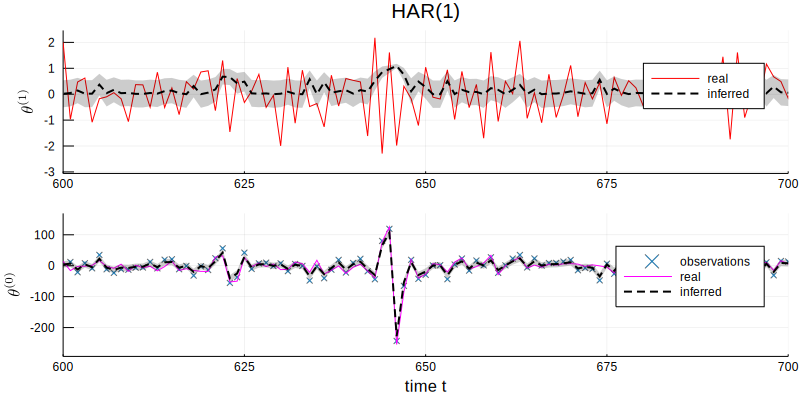

In [11]:
from = 600
upto = 700
scatter(y, markershape = :xcross, markeralpha = 0.6, xlims=(from, upto),
        ylims=(minimum(y[from:upto]) - 50, maximum(y[from:upto]) + 50),
        markersize = 2, xlabel="time t", ylabel=L"\theta^{(0)}", label="observations")
plot!(x, color=:magenta, label="real", title="")
pHAR = plot!(m_xt, ribbon=(sqrt.(v_xt), sqrt.(v_xt)),
      linestyle=:dash, linewidth = 2,
      color=:black,
      fillalpha = 0.2,
      fillcolor = :black,
      label="inferred")

plot(xlims=(from, upto), ylabel=L"\theta^{(1)}")
plot!(θ, color=:red, label="real", title="Inference 2d layer")
pAR = plot!(m_θ1t, ribbon=(sqrt.(v_θ1t), sqrt.(v_θ1t)),
      linestyle=:dash, linewidth = 2,
      color=:black,
      fillalpha = 0.2,
      fillcolor = :black,
      label="inferred", title="HAR(1)")

plot(pAR, pHAR, layout=(2,1), size=(800, 400))
#savefig("har.png")

# AR(1) model
As a benchamrk, we use the following RW model.
\begin{align*}
    &x_t = \theta^{(0)}x_{t-1} + p_t \quad p_t \sim \mathcal{N}(0, \gamma_x^{-1}) \\
    &y_t = x_t + m_t \quad m_t \sim \mathcal{N}(0, \gamma_y^{-1})
\end{align*}

where $\gamma_y^{-1} = 200$

In [12]:
include("../models/AR.jl")
ARorder = 1

1

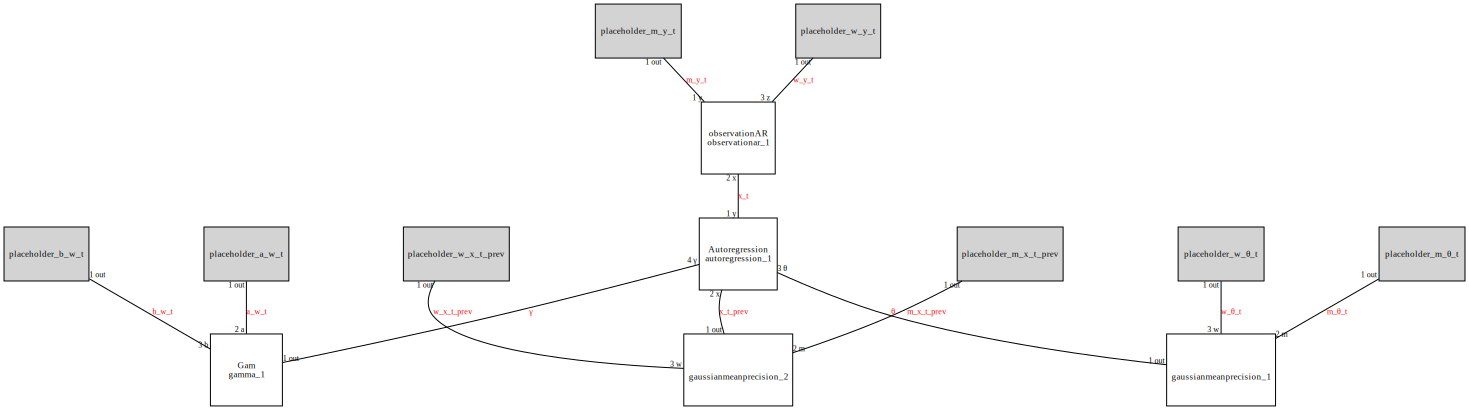

In [13]:
gar, qar = buildGraphAR(ARorder)
setCurrentGraph(gar)
ForneyLab.draw(gar)

In [15]:
# AR(1)
prs = Dict(:m_θ=>zeros(ARorder), :w_θ=>tiny*diagAR(ARorder),
           :m_x=>zeros(ARorder), :w_x=>tiny*diagAR(ARorder),
           :a=>0.00001, :b=>1.0)

# If Julia throws an error just ignore and re-run this (inference) block again
result = inferAR(qar, y, v_y, priors=prs, r_stats=true);

Observed 100%|██████████████████████████████████████████| Time: 0:00:01


In [16]:
# Inspect the results
marginals = result[1]
FAR = result[3]
posteriors = result[4]

m_x = posteriors[:m_x]
w_x = posteriors[:w_x]
m_θ = posteriors[:m_θ]
w_θ = posteriors[:w_θ]
a = posteriors[:a]
b = posteriors[:b]

m_ar = [x[1] for x in m_x]
v_ar = [v_x[1]^-1 for v_x in w_x[1:end]];

logPDFsAR = [logPDF(x[t], m_ar[t], v_ar[t]) for t in 1:length(y)]
WMSEsAR = [wmse(x[1:t], [est[1] for est in m_x[1:t]], [est[1]^-1 for est in w_x[1:t]]) for t in 1:length(y)];

In [18]:
println("Process noise variance\n=========")
println("Estimated ", mean(marginals[:γ])^-1)
println("True ", 1.0)

println("\nState\n=========")
println("Mean ", mean(marginals[:x_t]))
println("Var ", var(marginals[:x_t]))

Process noise variance
Estimated 380.0726373562485
True 1.0

State
Mean [-10.6909]
Var [131.046]


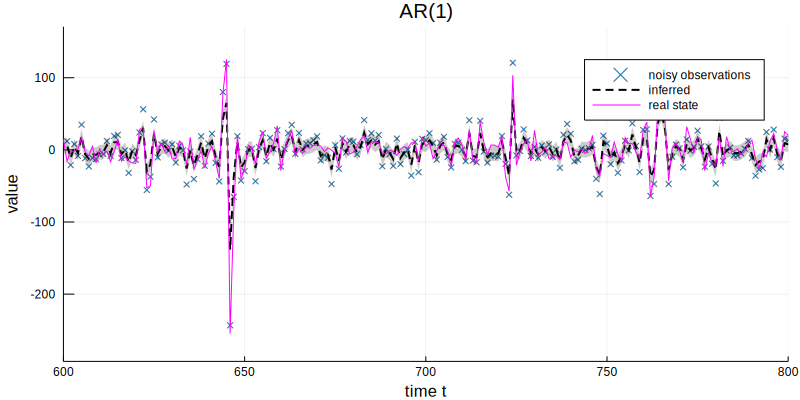

In [19]:
from = 600
upto = 800 # limit for building a graph 
scale = 1.0 # scale for the variance

scatter(y, label="noisy observations", 
        markershape = :xcross, markeralpha = 0.6,
        markersize = 2)
plot!(m_ar, ribbon=(sqrt.(v_ar), sqrt.(v_ar)),
      linestyle=:dash,linewidth = 2,
      color=:black,
      fillalpha = 0.2,
      fillcolor = :black,
      label="inferred")
plot!(x, color = :magenta, linewidth = 1.0, label="real state")
pAR = plot!(xlims=(from, upto),
            ylims=(minimum(y[from:upto]) - 50, maximum(y[from:upto]) + 50),
            size=(800, 400),
            xlabel="time t", ylabel="value", title="AR($ARorder)")

# RW model
As a benchamrk, we use the following RW model.
\begin{align*}
    &x_t = x_{t-1} + p_t \quad p_t \sim \mathcal{N}(0, \gamma_x^{-1}) \\
    &y_t = x_t + m_t \quad m_t \sim \mathcal{N}(0, \gamma_y^{-1})
\end{align*}

where $\gamma_y^{-1} = 200$

In [20]:
include("../models/AR.jl")
ARorder = 1

1

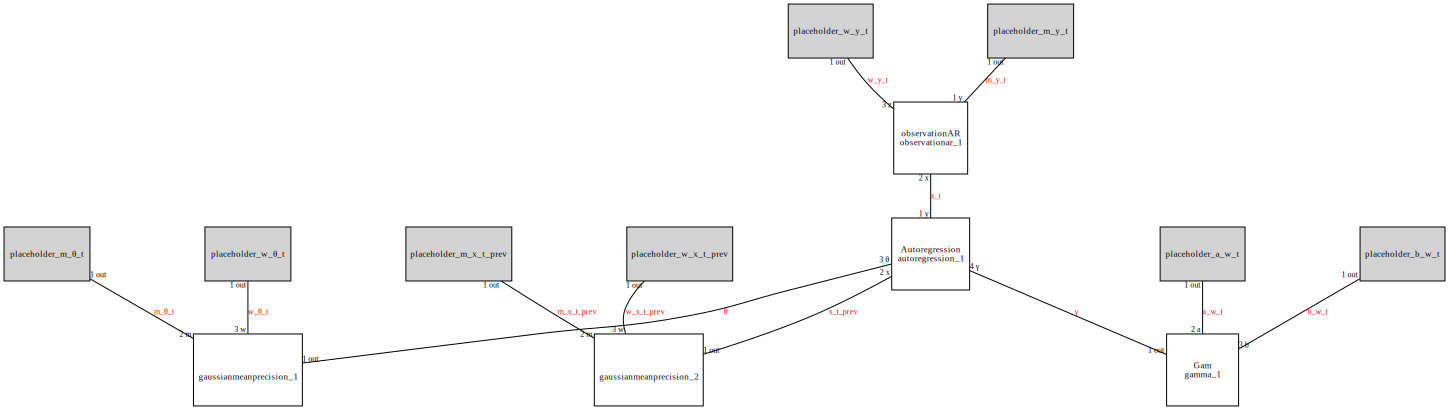

In [21]:
grw, qrw = buildGraphAR(ARorder)
setCurrentGraph(grw)
ForneyLab.draw(grw)

In [22]:
# RW
prs = Dict(:m_θ=>ones(ARorder), :w_θ=>huge*diagAR(ARorder),
           :m_x=>zeros(ARorder), :w_x=>tiny*diagAR(ARorder),
           :a=>0.00001, :b=>1.0)


# If Julia throws an error just ignore and re-run this (inference) block again
result = inferAR(qrw, y, v_y, priors=prs, r_stats=true);

Observed 100%|██████████████████████████████████████████| Time: 0:00:01


In [24]:
# Inspect the results
marginals = result[1]
FRW = result[3]
posteriors = result[4]

m_x = posteriors[:m_x]
w_x = posteriors[:w_x]
m_a = posteriors[:m_θ]
w_a = posteriors[:w_θ]
a = posteriors[:a]
b = posteriors[:b]

m_rw = [x[1] for x in m_x]
v_rw = [v_x[1]^-1 for v_x in w_x[1:end]];

logPDFsRW = [logPDF(x[t], m_rw[t], v_rw[t]) for t in 1:length(y)]
WMSEsRW = [wmse(x[1:t], [est[1] for est in m_x[1:t]], [est[1]^-1 for est in w_x[1:t]]) for t in 1:length(y)];

In [26]:
println("Process noise variance\n=========")
println("Estimated ", mean(marginals[:γ])^-1)
println("True ", 1.0)

println("\nState\n=========")
println("Mean ", mean(marginals[:x_t]))
println("Var ", var(marginals[:x_t]))

Process noise variance
Estimated 2.9999405650537777e8
True 1.0

State
Mean [-16.3155]
Var [200.0]


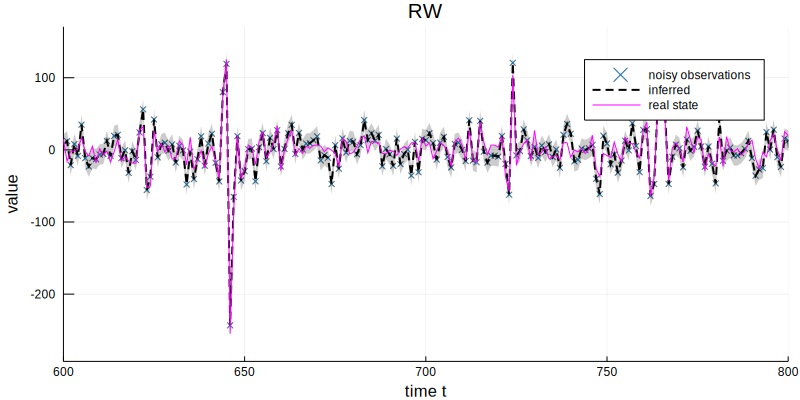

In [27]:
from = 600
upto = 800 # limit for building a graph 
scale = 1.0 # scale for the variance

scatter(y, label="noisy observations", 
        markershape = :xcross, markeralpha = 0.6,
        markersize = 2)
plot!(m_rw, ribbon=(sqrt.(v_rw), sqrt.(v_rw)),
      linestyle=:dash,linewidth = 2,
      color=:black,
      fillalpha = 0.2,
      fillcolor = :black,
      label="inferred")
plot!(x, color = :magenta, linewidth = 1.0, label="real state")
pRW = plot!(xlims=(from, upto),
            ylims=(minimum(y[from:upto]) - 50, maximum(y[from:upto]) + 50),
            size=(800, 400),
            xlabel="time t", ylabel="value", title="RW")

# Comparison (RW vs HAR)
To assess the performance of our model, we use the following metrics:
Free Energy:
$$F_t[q]\triangleq \int q(\mathbf{x}_t)\log\frac{q(\mathbf{x}_t)}{p(\mathbf{x}_t, y_t\big|\mathbf{y}_{1:t-1})}d\mathbf{x}_t$$

log PDF, i.e.:
$$-\frac{1}{2}\log{2\pi v_x}-\frac{(m_{x_{k}}-x_{k})^2}{2v_x}$$

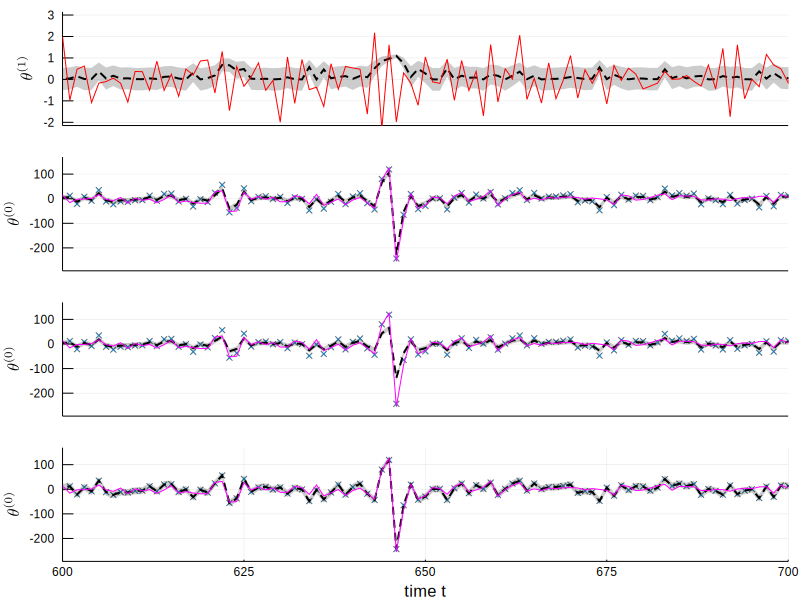

In [28]:
from = 600
upto = 700 # limit for building a graph 
scale = 1.0 # scale for the variance

plot(m_θ1t, ribbon=(sqrt.(v_θ1t), sqrt.(v_θ1t)),
      linestyle=:dash, linewidth = 2,
      color=:black,
      fillalpha = 0.2,
      fillcolor = :black,
      label=["inferred", "inferred"])
plot!(θ, color=:red, label="real", title="")
pHAR1 = plot!(ylabel=L"\theta^{(1)}", title="", legend=false, xticks=[], ylims=[-2, 3])

scatter(y, label="noisy observations", 
        markershape = :xcross, markeralpha = 0.6,
        markersize = 2)
plot!(m_xt, ribbon=(sqrt.(v_xt), sqrt.(v_xt)),
      linestyle=:dash, linewidth = 2,
      color=:black,
      fillalpha = 0.2,
      fillcolor = :black,
      label="inferred")
plot!(x, color = :magenta, linewidth = 1.0, label="real state",  ylabel=L"\theta^{(0)}")
pHAR = plot!(title="", legend=false, ylims=(minimum(y[from:upto]) - 50, maximum(y[from:upto]) + 50), xticks=[])

scatter(y, label="noisy observations", 
        markershape = :xcross, markeralpha = 0.6,
        markersize = 2)
plot!(m_ar, ribbon=(sqrt.(v_ar), sqrt.(v_ar)),
      linestyle=:dash,linewidth = 2,
      color=:black,
      fillalpha = 0.2,
      fillcolor = :black,
      label=["inferred", "inferred"])
plot!(x, color = :magenta, linewidth = 1.0, label="real state")
pAR = plot!(ylabel=L"\theta^{(0)}", ylims=(minimum(y[from:upto]) - 50, maximum(y[from:upto]) + 50), xticks=[])

scatter(y, label="noisy observations", 
        markershape = :xcross, markeralpha = 0.6,
        markersize = 2)
plot!(m_rw, ribbon=(sqrt.(v_rw), sqrt.(v_rw)),
      linestyle=:dash,linewidth = 2,
      color=:black,
      fillalpha = 0.2,
      fillcolor = :black,
      label="inferred")
plot!(x, color = :magenta, linewidth = 1.0, label="real state")
pRW = plot!(xlabel="time t",  ylabel=L"\theta^{(0)}", ylims=(minimum(y[from:upto]) - 50, maximum(y[from:upto]) + 50))

plot(pHAR1, pHAR, pAR, pRW, xlims=(from, upto), 
    layout=(4,1),  size=(800, 600), legend=false)
#savefig("inference.png")


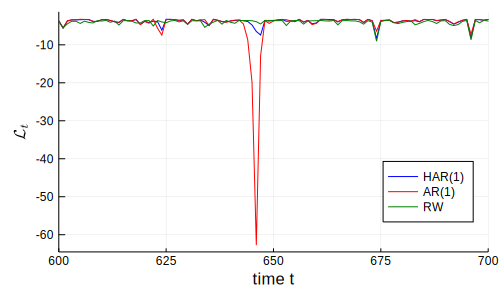

In [29]:
# log PDFs
from = 600; upto = 700
plot(logPDFsHAR[1:end], color=:blue, label="HAR($HARorder)")
plot!(logPDFsAR[1:end], color=:red, label="AR($ARorder)", xlabel="time t", ylabel=L"\mathcal{L}_t", size=(500, 300), legend=:bottomright)
plt = plot!(logPDFsRW[1:end], color=:green, label="RW", xlims=(from, upto))
#savefig("logPDF.png")

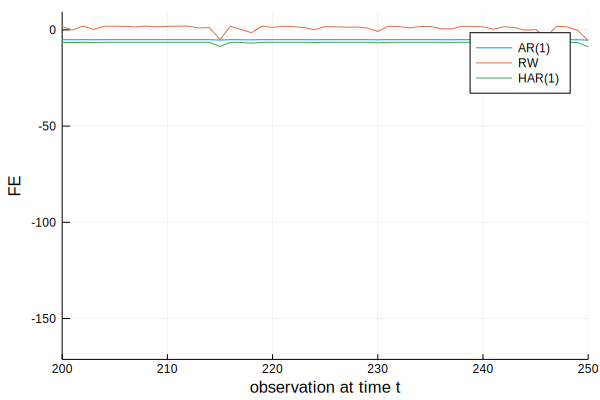

In [30]:
# Free energy
from, upto = 200, 250
plot(FAR[2:end], label="AR($ARorder)", xlims=(from, upto))
plot!(FRW[2:end], label="RW", xlims=(from, upto))
plot!(FHAR[2:end], label="HAR($HARorder)", xlabel="observation at time t", ylabel="FE")

In [31]:
sum(logPDFsAR)

-4025.852358920905

In [32]:
sum(logPDFsRW)

-4044.611427373593

In [33]:
sum(logPDFsHAR)

-3789.341293249901

In [34]:
sum(logPDFsAR) < sum(logPDFsHAR)

true

In [35]:
abs(sum(logPDFsHAR) - sum(logPDFsAR))

236.51106567100396

# Animation

In [37]:
v_x = v_xt # variances of estimated state
m_ar = m_xt
toshow = 20 # number of points to plot at once

anim = @animate for i in 300:length(m_ar)-toshow
    s = plot(xticks = i:div(toshow, 2):i+toshow, size=(800, 300));
    ylims!(minimum(y) - .1, maximum(y) + .1);
    scatter!(collect(i:i+toshow), y[i:i+toshow], label="observations", 
            markershape = :xcross, markeralpha = 0.6,
            markersize = 2)
    
    plot!(collect(i:i+toshow), m_ar[i:i+toshow], ribbon=(sqrt.(v_x[i:i+toshow]), sqrt.(v_x[i:i+toshow])),
          linestyle=:dash, linewidth = 2, color=:black, fillalpha = 0.2, fillcolor = :black,
          label="inferred", title = "1st layer")
    
    plot!(collect(i:i+toshow), x[i:i+toshow], color = :magenta, linewidth = 1.0, label="real", xlabel="time t", ylabel=L"\theta^{(0)}")
end

Animation("/var/folders/jn/1xv7kskx42v_97gx1xd8y_g40000gq/T/tmp8uCcnB", ["000001.png", "000002.png", "000003.png", "000004.png", "000005.png", "000006.png", "000007.png", "000008.png", "000009.png", "000010.png"  …  "000672.png", "000673.png", "000674.png", "000675.png", "000676.png", "000677.png", "000678.png", "000679.png", "000680.png", "000681.png"])

In [38]:
gif(anim, "../gifs/1stHAR.gif", fps = 10)

┌ Info: Saved animation to 
│   fn = /Users/albertpod/Documents/Julia/VariationalBayes/gifs/1stHAR.gif
└ @ Plots /Users/albertpod/.julia/packages/Plots/oiirH/src/animation.jl:90


Plots.AnimatedGif("/Users/albertpod/Documents/Julia/VariationalBayes/gifs/1stHAR.gif")

In [39]:
v_x = v_θ1t # variances of estimated state
m_ar = m_θ1t
toshow = 20 # number of points to plot at once

anim = @animate for i in 300:length(m_ar)-toshow
    s = plot(xticks = i:div(toshow, 2):i+toshow, size=(800, 300));
    ylims!(-10, 10);
    
    plot!(collect(i:i+toshow), m_ar[i:i+toshow], ribbon=(sqrt.(v_x[i:i+toshow]), sqrt.(v_x[i:i+toshow])),
          linestyle=:dash, linewidth = 2, color=:black, fillalpha = 0.2, fillcolor = :black,
          label="inferred", title = "2d layer")
    
    plot!(collect(i:i+toshow), θ[i:i+toshow], color = :red, linewidth = 1.0, label="real", ylabel=L"\theta^{(1)}")
end

Animation("/var/folders/jn/1xv7kskx42v_97gx1xd8y_g40000gq/T/tmp1tK7CS", ["000001.png", "000002.png", "000003.png", "000004.png", "000005.png", "000006.png", "000007.png", "000008.png", "000009.png", "000010.png"  …  "000672.png", "000673.png", "000674.png", "000675.png", "000676.png", "000677.png", "000678.png", "000679.png", "000680.png", "000681.png"])

In [40]:
gif(anim, "../gifs/2stHAR.gif", fps = 10)

┌ Info: Saved animation to 
│   fn = /Users/albertpod/Documents/Julia/VariationalBayes/gifs/2stHAR.gif
└ @ Plots /Users/albertpod/.julia/packages/Plots/oiirH/src/animation.jl:90


Plots.AnimatedGif("/Users/albertpod/Documents/Julia/VariationalBayes/gifs/2stHAR.gif")

In [41]:
# Plotting MSE
anim = @animate for i in 1:length(logPDFsRW)
    s = plot(size=(800, 300))
    ylims!(-20, 0)
    xlims!(1, length(logPDFsRW))
    plot!(collect(1:i), logPDFsHAR[1:i], xlabel="time t", ylabel=L"\mathcal{L}_t", color=:blue, label="HAR($HARorder)")
    plot!(collect(1:i), logPDFsAR[1:i], color=:red, label="AR($HARorder)")
    plot!(collect(1:i), logPDFsRW[1:i], color=:green, label="RW")
end;

In [42]:
gif(anim, "../gifs/logPDFevo.gif", fps = 10)

┌ Info: Saved animation to 
│   fn = /Users/albertpod/Documents/Julia/VariationalBayes/gifs/logPDFevo.gif
└ @ Plots /Users/albertpod/.julia/packages/Plots/oiirH/src/animation.jl:90


Plots.AnimatedGif("/Users/albertpod/Documents/Julia/VariationalBayes/gifs/logPDFevo.gif")